# Mark rooftops with u-net

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/M_DV_V2022

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/M_DV_V2022


In [84]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, Flatten, \
                         UpSampling2D, Conv2DTranspose, MaxPooling2D, \
                         Dropout, Concatenate, BatchNormalization, Activation, \
                         concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.image import resize

import keras.backend as K
import tensorflow as tf

### Load data

In [33]:
X_train = np.load("data/u_net_roofs/X_data.npy") 
X_70_train = np.load("data/u_net_roofs/X_70_data.npy")
y_train = np.load("data/u_net_roofs/y_data.npy")

X_val = np.load("data/u_net_roofs/X_data_val.npy")
X_70_val = np.load("data/u_net_roofs/X_70_data_val.npy")
y_val = np.load("data/u_net_roofs/y_data_val.npy")

X_test = np.load("data/u_net_roofs/X_data_test.npy")
X_70_test = np.load("data/u_net_roofs/X_70_data_test.npy")
y_test = np.load("data/u_net_roofs/y_data_test.npy")


In [47]:
def redesign_y(y):
  n,r1,c1,d = y.shape
  # Adds a new dimension of layer too have two class problem.
  yy = np.append(y, np.zeros((n, r1, c1,d)), axis=3)
  for i in range(int(y.max()-1)):  
    yy = np.append(yy, np.zeros((n, r1, c1,d)), axis=3)
  #yy[yy >= 0.001] = 1
  yy1 = yy.copy()
  yy1[:,:,:,0] = 0 # reset map
  for i in range(n):
    values = yy[i,:,:,0]
    for r in range(r1):
      for c in range(c1):
        value = yy[i,r,c,0]
        yy1[i,r,c,int(value)] = 1

  return yy1

In [48]:
y_train = redesign_y(y_train)
y_val = redesign_y(y_val)
y_test = redesign_y(y_test)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(100, 128, 128, 2)
(20, 128, 128, 2)
(50, 128, 128, 2)


In [34]:
#When raw data
X_train[:,:,:,:-1] /= 100
X_val[:,:,:,:-1] /= 100
X_test[:,:,:,:-1] /= 100
X_70_train[:,:,:,:-1] /= 2000
X_70_val[:,:,:,:-1] /= 2000
X_70_test[:,:,:,:-1] /= 2000

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    yy1, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [119]:
print(X_train.shape)
print(X_70_train.shape)

(100, 128, 128, 177)
(100, 64, 64, 220)


### Make u net

In [113]:
def rationalConv(x, filters=16, kernel_size=(3,3), padding="same", start=7, end=3):
    """
    Where ordinary convolutions down-scale by an integer stride, 
    the rational version up-samples and down-scales an integer stride to 
    reach a desired rational upscaling.

    Example: 7 -> 3 => 7 * bilinear(9/7) = 9, 9 / conv(3) = 3
    """
    size = x.shape
    stride = np.ceil(start/end).astype(int)
    scaling = (end*stride)/start
    
    x = resize(x, tf.constant(np.round([size[1]*scaling, size[2]*scaling]), dtype="int32"))
    if stride > 1:
        x = Conv2D(filters=filters, kernel_size=kernel_size, strides = (stride,stride), padding=padding)(x)
    return x

def rationalConvTransposed(x, filters=16, kernel_size=(3,3), padding="same", start=3, end=7):
    """
    Where ordinary transposed convolutions up-scale by an integer stride, 
    the rational version up-scales an integer stride and down-samples to 
    reach a desired rational upscaling.
    
    Example: 3 -> 7 => 3 * convTr(3) = 9, 9 * bilinear(7/9) = 7
    """
    size = x.shape
    stride = np.ceil(end/start).astype(int)
    scaling = end/start
    
    if stride > 1:
        x = Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides = (stride,stride), padding=padding)(x)
    x = resize(x, tf.constant(np.round([size[1]*scaling, size[2]*scaling]), dtype="int32"))
    return x





"""
Version of U-Net with dropout and size preservation (padding= 'same')
""" 
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x


def get_unet(input_img1, input_img2, n_filters = 16, dropout = 0.1, batchnorm = True, n_classes = 2):

    m1 = input_img1
    m2 = input_img2
    m3 = rationalConvTransposed(m2, start=1, end=2)
    
    m4 = concatenate([m1, m3])

    # Contracting Path
    c1 = conv2d_block(m4, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2), name="first_pole")(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    strides = (2,2)
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = strides, padding = 'same')(c5)
    #r6 = rationalConvTransposed(c4, start=1, end=2)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = strides, padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = strides, padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = strides, padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
    model = Model(inputs=[m1,m2], outputs=[outputs])
    return model



def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


### Show data - 5 random images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[69 53 57 40 13]


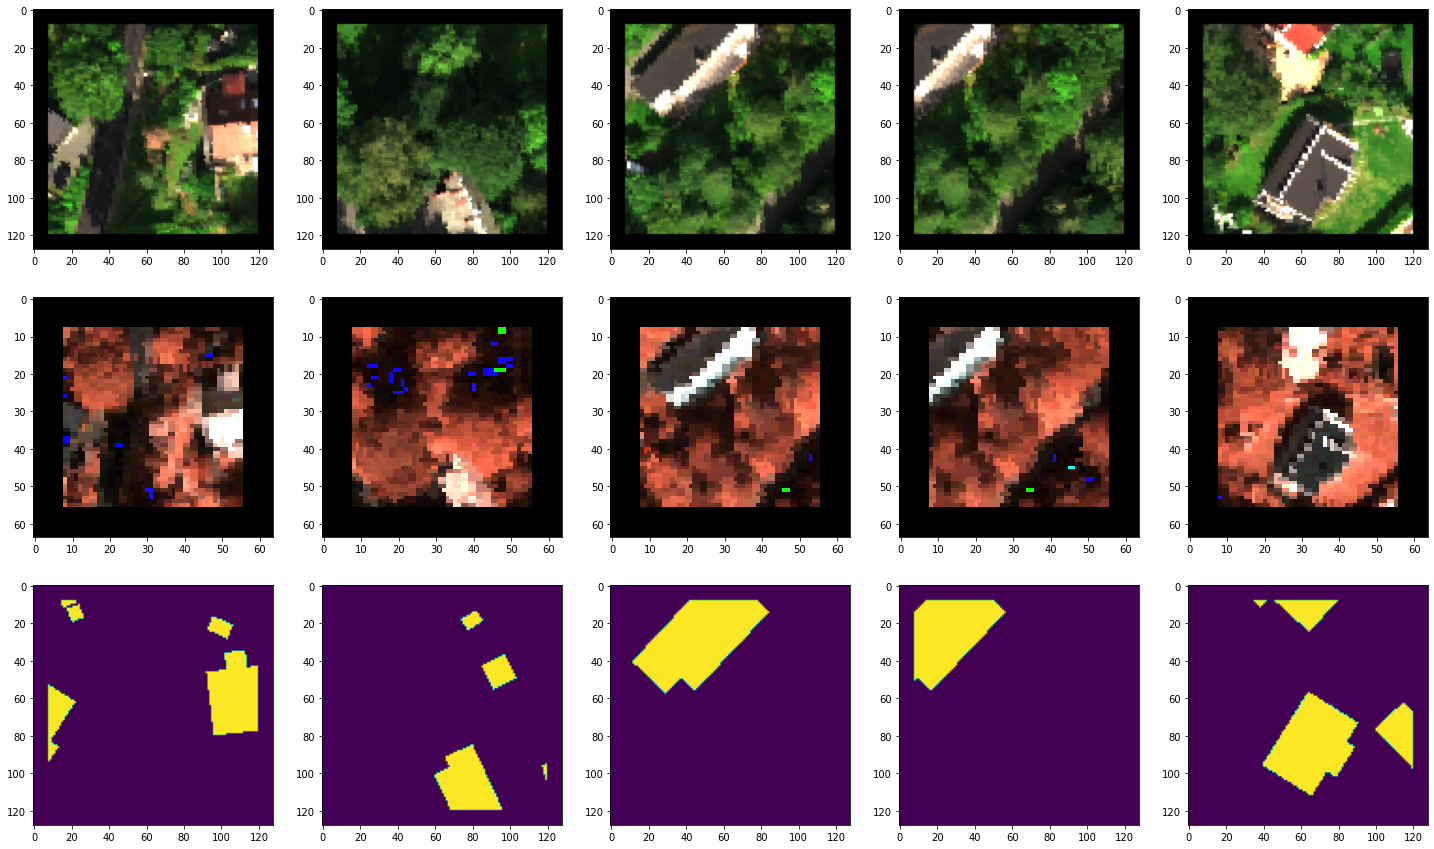

In [90]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize = (25,15))

indx = np.random.randint(0,high=X_train.shape[0],size=5)
print(indx)
for i in range(5):
    ax[0,i].imshow(np.dstack((X_train[indx[i]][:,:,76],
                              X_train[indx[i]][:,:,46],
                              X_train[indx[i]][:,:,21])))
    #PCAax[0,i].imshow(X_train[indx[i]][:,:,0:3])
    ax[1,i].imshow(np.dstack((X_70_train[indx[i]][:,:,137],
                              X_70_train[indx[i]][:,:,194],
                              X_70_train[indx[i]][:,:,207])))
    ax[2,i].imshow(y_train[indx[i]].argmax(axis=2))
plt.show()

### Set up u net

In [128]:
input_img1 = Input(shape=(128,128,177))
input_img2 = Input(shape=(64,64,220))
model = get_unet(input_img1, input_img2, n_classes=2)

model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

model.summary()


Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_74 (InputLayer)          [(None, 64, 64, 220  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_transpose_95 (Conv2DTra  (None, 128, 128, 16  31696      ['input_74[0][0]']               
 nspose)                        )                                                                 
                                                                                                  
 input_73 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                77)]                                                       

In [129]:
h = model.fit([X_train, X_70_train],
              y_train, 
           validation_data=([X_val, X_70_val],y_val), 
           batch_size=16,
           epochs=200)

Epoch 1/200
7/7 [==============================] - 7s 277ms/step - loss: 0.7117 - accuracy: 0.7069 - val_loss: 2.2981 - val_accuracy: 0.8095
Epoch 2/200
7/7 [==============================] - 1s 161ms/step - loss: 0.6232 - accuracy: 0.7902 - val_loss: 3.5593 - val_accuracy: 0.8676
Epoch 3/200
7/7 [==============================] - 1s 154ms/step - loss: 0.5610 - accuracy: 0.8210 - val_loss: 1.9747 - val_accuracy: 0.8532
Epoch 4/200
7/7 [==============================] - 1s 181ms/step - loss: 0.5148 - accuracy: 0.8441 - val_loss: 1.3603 - val_accuracy: 0.8678
Epoch 5/200
7/7 [==============================] - 1s 158ms/step - loss: 0.4776 - accuracy: 0.8701 - val_loss: 1.7277 - val_accuracy: 0.8657
Epoch 6/200
7/7 [==============================] - 1s 154ms/step - loss: 0.4393 - accuracy: 0.9112 - val_loss: 1.2919 - val_accuracy: 0.8677
Epoch 7/200
7/7 [==============================] - 1s 159ms/step - loss: 0.4080 - accuracy: 0.9322 - val_loss: 1.1618 - val_accuracy: 0.8694
Epoch 8/200
7

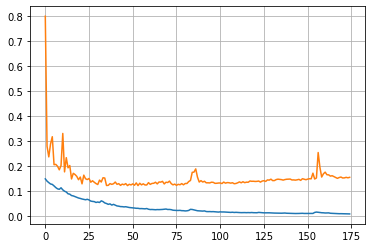

In [132]:
plt.plot(h.history['loss'][25:])
plt.plot(h.history['val_loss'][25:])
plt.grid()

### Validate prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


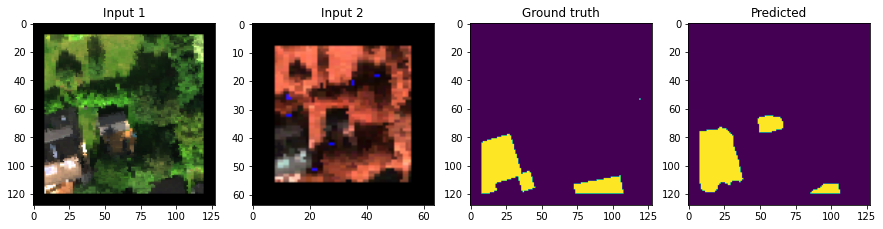

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


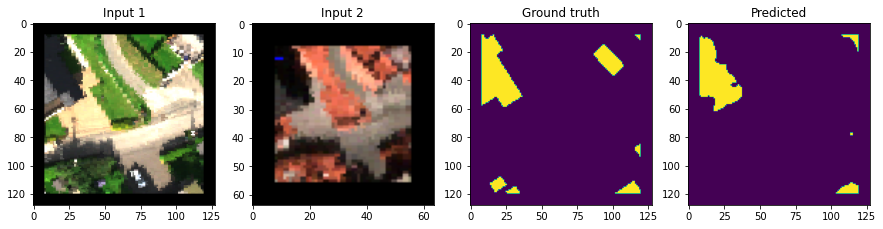

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


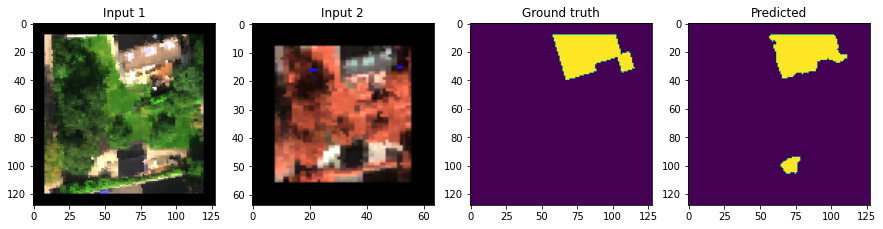

In [133]:
for _ in range(3):
  x = np.random.randint(X_val.shape[0])
  fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1,ncols=4, figsize = (15,15))
  ax1.imshow(np.dstack((X_val[x:x+1][0][:,:,76],
                        X_val[x:x+1][0][:,:,46],
                        X_val[x:x+1][0][:,:,21])))
  
  # PCA ax1.imshow(X_val[x:x+1][0][:,:,0:3])
  ax1.set_title("Input 1")

  ax2.imshow(np.dstack((X_70_val[x:x+1][0][:,:,137],
                        X_70_val[x:x+1][0][:,:,194],
                        X_70_val[x:x+1][0][:,:,207])))
  ax2.set_title("Input 2")


  ax3.imshow(y_val[x:x+1][0].argmax(axis=2))
  ax3.set_title("Ground truth")
  pred = model.predict([X_val[x:x+1], X_70_val[x:x+1]])[0].argmax(axis=2)
  ax4.imshow(pred)
  ax4.set_title("Predicted")
  plt.show()

## Test on unseen data

In [135]:
pred = model.predict([X_test, X_70_test])

In [136]:
from sklearn.metrics import balanced_accuracy_score

In [137]:
print("Metrics on whole pred and useen")
print(f"f1 score: {f1_score(y_test.argmax(axis=3).flatten(), pred.argmax(axis=3).flatten())}")
print(f"acc score: {accuracy_score(y_test.argmax(axis=3).flatten(), pred.argmax(axis=3).flatten())}")

Metrics on whole pred and useen
f1 score: 0.8000860577483349
acc score: 0.972777099609375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


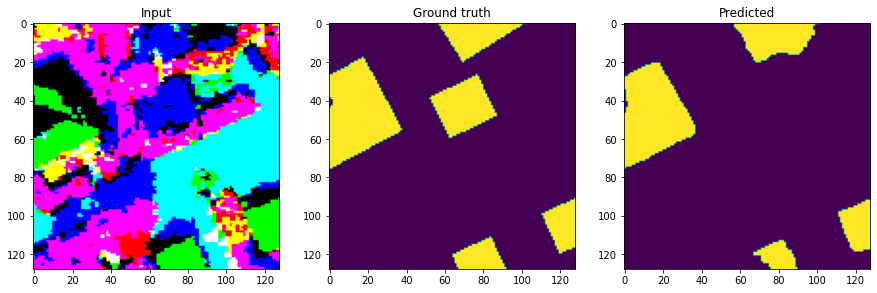

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Acc score: 0.94049072265625
f1 score: 0.8274641656344011


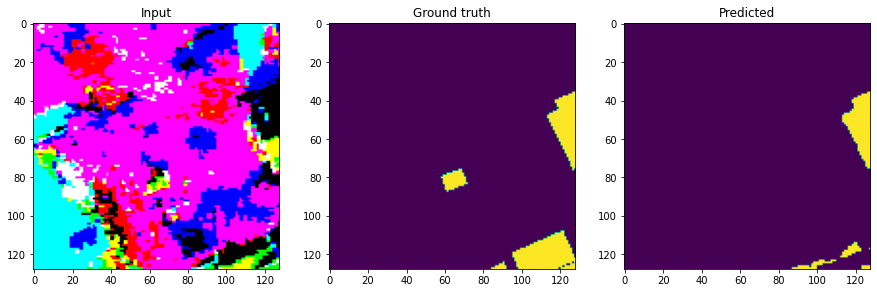

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Acc score: 0.96929931640625
f1 score: 0.630418809698751


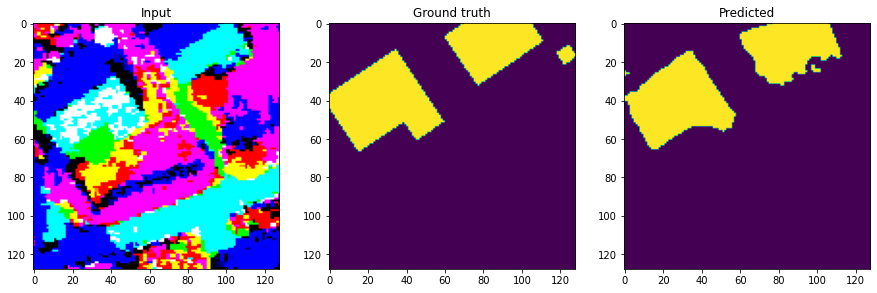

Acc score: 0.9769287109375
f1 score: 0.932475884244373


In [ ]:
for _ in range(3):
  x = np.random.randint(pred.shape[0])
  fig, (ax1, ax2, ax3) = plt.subplots(nrows=1,ncols=3, figsize = (15,15))
  #ax1.imshow(np.dstack((X_test[x:x+1][0][:,:,76],
  #                      X_test[x:x+1][0][:,:,46],
  #                      X_test[x:x+1][0][:,:,21])))
  ax1.imshow(X_test[x:x+1][0][:,:,0:3])
  ax1.set_title("Input")
  ax2.imshow(y_test[x:x+1][0].argmax(axis=2))
  ax2.set_title("Ground truth")
  ax3.imshow(pred[x:x+1][0].argmax(axis=2))
  ax3.set_title("Predicted")
  plt.show()

  # Metrics  w threshold:
  pred[x:x+1,:,:,0][pred[x:x+1,:,:,0] > .5] = 1
  pred[x:x+1,:,:,0][pred[x:x+1,:,:,0] <= .5] = 0
  pred[x:x+1,:,:,1][pred[x:x+1,:,:,1] > .5] = 1
  pred[x:x+1,:,:,1][pred[x:x+1,:,:,1] <= .5] = 0

  print(f"Acc score: {accuracy_score(y_test[x:x+1][0].argmax(axis=2).flatten(),\
                                     pred[x:x+1][0].argmax(axis=2).flatten())}")
  print(f"f1 score: {f1_score(y_test[x:x+1][0].argmax(axis=2).flatten(),\
                                     pred[x:x+1][0].argmax(axis=2).flatten())}")
  
  

In [ ]:
import seaborn as sns
sns.displot(pred[:,:,:,0])

ValueError: ignored

In [ ]:
!git pull

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/stianteien/M_DV_V2022
   032c1eb..e07fd6c  master     -> origin/master
Updating 032c1eb..e07fd6c
Fast-forward
 roofs_w_unet/roof_u-net.ipynb | 844 ++++++++++++++++++++++++++----------------
 1 file changed, 526 insertions(+), 318 deletions(-)


# Test for 5 periods and see mean results

In [ ]:
epochs = 100
f1s = []
accs = []

for i in range(5):
  input_img = Input(shape=(128,128,6))
  model = get_unet(input_img, n_classes=2)

  model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
  
  h = model.fit(X_train, y_train, 
           batch_size=16,
           epochs=epochs,
           verbose=0)
  
  pred = model.predict(X_test)
  f1 = f1_score(y_test.argmax(axis=3).flatten(), pred.argmax(axis=3).flatten())
  acc = accuracy_score(y_test.argmax(axis=3).flatten(), pred.argmax(axis=3).flatten())
  f1s.append(f1)
  accs.append(acc)

  print(f"round {i+1} of {5}, f1: {f1}, acc: {acc}")



round 1 of 5, f1: 0.5432821939489367, acc: 0.8906611328125
round 2 of 5, f1: 0.6652040132798995, acc: 0.9330709228515625
round 3 of 5, f1: 0.6107885682056444, acc: 0.9171099853515625
round 4 of 5, f1: 0.6228499705581555, acc: 0.922752197265625
round 5 of 5, f1: 0.5861486720594282, acc: 0.91251611328125


In [ ]:
metrics = np.array([f1s, accs])
np.save("unetmetric.npy", metrics)

In [ ]:
f1_df = pd.DataFrame(metrics.T, columns=["f1_score", "accuracy"])
f1_df

,f1_score,accuracy
0,0.543282,0.890661
1,0.665204,0.933071
2,0.610789,0.917110
3,0.622850,0.922752
4,0.586149,0.912516


In [ ]:
import seaborn as sns
import pandas as pd

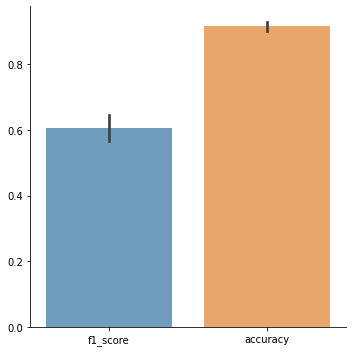

In [ ]:
sns.catplot(data=f1_df,
            kind="bar",
            ci='sd',
            alpha=0.7)

In [ ]:
f1s

array([0.5322395 , 0.54041918, 0.45859386, 0.47740101, 0.63502902])